In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

In [2]:
from scipy.special import softmax
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy.optimize import LinearConstraint, Bounds, minimize
import warnings
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")

class SchoolManifold():

    def __init__(self, embeddings_df: pd.DataFrame, k = 15, ):
        self.embeddings_df = embeddings_df
        self.embeddings = self.embeddings_df.drop(labels = ["unitid"], axis =1)

        self.k = k

    
    def _compute_neighbors(self, k: int):
        knn = NearestNeighbors(n_neighbors = k, algorithm="auto")
        knn.fit(self.embeddings.values)
        dists, indices = knn.kneighbors(self.embeddings.values)
        self.neighbor_dists = dists
        self.neighbor_indices = indices


    def preprocess_for_target(self, target_df: pd.DataFrame, target_col_ind: int = None, target_col_lab = None, total_column_lab = None):
        if (target_col_ind is not None):
            target_col_lab = target_df.columns[target_col_ind]

        if (target_col_lab is None):
            raise ValueError("Either target_col_ind or target_col_lab must not be None")

        self.total_column_lab = total_column_lab
        merged = pd.merge(self.embeddings_df, target_df, how= "inner", on = "unitid")
        
        self.embeddings = merged[self.embeddings.columns]
        self._compute_neighbors(self.k)

        self.target_df = merged[target_df.columns]
        self.features = self.target_df.drop(labels = ["unitid", target_col_lab], axis = 1)
        orig_columns = self.features.columns
        self.target = self.target_df[target_col_lab]
        self.schools = self.target_df["unitid"]

        inds_of_target_in_original = merged.index.values
        neighbor_inds_of_target_in_original = self.neighbor_indices[inds_of_target_in_original]
        neighbor_dists_of_target_col = self.neighbor_dists[inds_of_target_in_original]

        vals_of_target_col = merged[target_col_lab].values
        neighbor_vals_of_target_col =  vals_of_target_col[neighbor_inds_of_target_in_original]
        
        features_of_target_col = merged[orig_columns].values
        neighbor_features_of_target_col = features_of_target_col[neighbor_inds_of_target_in_original]

        mask = neighbor_vals_of_target_col > 1.1 * vals_of_target_col.reshape(-1, 1)
        neighbor_weights_of_target_col = np.where(mask, neighbor_dists_of_target_col, np.PINF)
        neighbor_weights_of_target_col = softmax(-neighbor_weights_of_target_col, axis = 1)

        self.mask = mask
        self.v_star = (neighbor_vals_of_target_col * neighbor_weights_of_target_col).sum(axis = 1)
        self.weights =  neighbor_weights_of_target_col
        self.neighbor_features = neighbor_features_of_target_col
        self.neighbor_target = neighbor_vals_of_target_col
        
        if (total_column_lab is not None):
            self.total_column = self.features[total_column_lab].values.reshape(-1,1)
            self.total_column_index = list(self.features.columns).index(total_column_lab)
            self.neighbor_features[:, :, self.total_column_index] = self.total_column
        
        self.vstars = np.where(np.isnan(self.v_star), self.target.values, self.v_star)
    

    def compute_deltas(self, reg, mode = "projection", eps = 0.1):
        self.reg = reg
        self.adjusted_features = np.sum(self.neighbor_features * self.weights[:, :, None], axis = 1)
        self.adjusted_features = np.where(np.isnan(self.adjusted_features), self.features.values, self.adjusted_features)

        if mode == "projection":
            # maintaining total spending constraint
            if (self.total_column_lab):
                # all_but_total_column = [x for x in range(self.features.shape[-1]) if x != self.total_column_index]
                # non_total_adjusted_features = self.adjusted_features[:, all_but_total_column]
                # non_total_features = self.features.values[:, all_but_total_column]
                # non_total_adjusted_features = non_total_adjusted_features / np.sum(non_total_adjusted_features, axis = 1).reshape(-1, 1)
                # non_total_adjusted_features = non_total_adjusted_features * np.sum(non_total_features, axis = 1).reshape(-1, 1)
                # self.adjusted_features[:, all_but_total_column] =  non_total_adjusted_features
                
                self.adjusted_features_df = pd.DataFrame(self.adjusted_features, columns = self.features.columns)
                self.deltas = self.adjusted_features - self.features.values
            
            if type(reg) == xgb.core.Booster:
                self.vhats = reg.predict(xgb.DMatrix(self.adjusted_features_df))
        
        if mode == "optimize":
            def objective_xgb(x, reg, df_cols):
                x_df = pd.DataFrame(x.reshape(1, -1), columns=list(df_cols))
                x = xgb.DMatrix(x_df)
                v = reg.predict(x)
                return -v
            
            def objective(x, reg, df_cols):
                v = reg.predict(pd.DataFrame(x.reshape(1,-1), columns=list(df_cols)))
                return -v
            d = self.adjusted_features.shape[-1]
            positive_constraint_A = np.eye(d)
            positive_constraint = LinearConstraint(positive_constraint_A, lb = 0, ub = np.inf)
            
            distance_constraint_A = np.eye(d)
            self.vhats = []
            for school, x0 in enumerate(self.features.values):
                if (np.allclose(x0, self.adjusted_features[school])):
                    self.vhats.append(self.target[school])
                    continue
                constraints = []

                vstar = self.vstars[school]

                if (self.total_column_lab is not None):
                    ub = np.zeros(d)
                    ub[self.total_column_index] = x0[self.total_column_index]
                    other_cols = [x for x in range(d) if x != self.total_column_index]
                    ub[other_cols] = x0[other_cols] + eps * x0[other_cols]
                    
                    bounds = Bounds(lb = np.zeros(d), ub = ub, keep_feasible=True)
                else:
                    bounds = Bounds(lb = np.zeros(d), ub = x0.flatten() + eps*x0.flatten(), keep_feasible=True)
                
                if type(reg) == xgb.core.Booster:
                    res = minimize(objective_xgb, x0= x0.flatten(), args = (reg, self.features.columns), method="Powell", bounds = bounds)
                else:
                    res = minimize(objective, x0= x0.flatten(), args = (reg, self.features.columns), method="Powell", bounds = bounds)

                self.vhats.append(-res.fun)
                self.adjusted_features[school] = res.x
                print(f"vhat: {-res.fun}, vstar: {vstar}, orig: {self.target[school]}")
                
                
        outcome_results = np.zeros((len(self.vhats), 3))
        outcome_results[:, 0] = self.target[:len(self.vhats)]
        outcome_results[:, 1] = self.vhats[:len(self.vhats)]
        outcome_results[:, 2] = self.vstars[:len(self.vhats)]
        
        outcome_results_df = pd.DataFrame(outcome_results, columns = ["original", "vhat", "vstar"])
        self.adjusted_features_df = pd.DataFrame(self.adjusted_features, columns = self.features.columns)

        self.results = pd.concat((outcome_results_df, self.adjusted_features_df), axis = 1)
        self.deltas = self.adjusted_features - self.features.values

        return self.results

        

### Yield Efficiency

In [3]:
ic_mca = pd.read_csv("../datasets/Clusters/IC_CLUSTERS_AND_MCA.csv")
ic_mca = ic_mca.loc[:, ic_mca.columns != "ic_cluster"]

yield_efficiency = pd.read_csv("../datasets/Target Features/manual_per_dollar_expense.csv", index_col=0)

In [4]:
manifold = SchoolManifold(ic_mca)

In [5]:
# yeff_no_total = yield_efficiency.drop("Total expenses", axis = 1)
manifold.preprocess_for_target(yield_efficiency, target_col_lab="log_yield_per_dollar", total_column_lab="Total expenses")

/home/acowlagi/.conda/envs/datathon/lib/python3.9/site-packages/scipy/special/_logsumexp.py:214: RuntimeWarning: invalid value encountered in subtract
  return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


In [6]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import pickle

xgb_reg = xgb.Booster()
xgb_reg.load_model("../models/manual_features_yield_per_dollar.json")

In [7]:
results = manifold.compute_deltas(xgb_reg, mode = "optimize")

vhat: 4.509435653686523, vstar: 4.505462537340737, orig: 2.544717263849523
vhat: 1.9876381158828735, vstar: 2.2563277750274335, orig: 1.0010583064021
vhat: 4.784646034240723, vstar: 4.629689608672587, orig: 2.801798500692677
vhat: 2.8726460933685303, vstar: 1.7367731768346324, orig: 0.8878571919126474
vhat: 4.245884418487549, vstar: 5.922497087602809, orig: 4.218222831585885
vhat: 3.0982460975646973, vstar: 3.0306200164349986, orig: 2.18588078386843
vhat: 1.5762929916381836, vstar: 2.032932156607036, orig: 1.369880177216872
vhat: 1.635478138923645, vstar: 3.7058306978184983, orig: 1.2141330712472398
vhat: 2.922410249710083, vstar: -0.24761400147755622, orig: -0.8895302150930406
vhat: 1.9499626159667969, vstar: -0.023828258030507345, orig: -0.4136643163796491
vhat: 4.231893539428711, vstar: 5.433822290332729, orig: 4.071283127616505
vhat: 2.686314105987549, vstar: 1.496225346703634, orig: 0.4598798272403258
vhat: 1.9876381158828735, vstar: -0.7404072653139657, orig: -1.272095334554283
v

,original,vhat,vstar,Total expenses,Institutional grants (funded)_per_dollar,Institutional grants (unfunded)_per_dollar,Sales and services of educational activities - Total_per_dollar,Sales and services of auxiliary enterprises - Total_per_dollar,Instruction-Total amount_per_dollar,Research-Total amount_per_dollar,Public service-Total amount_per_dollar,Academic support-Total amount_per_dollar,Student service-Total amount_per_dollar,Institutional support-Total amount_per_dollar,Auxiliary enterprises-Total amount_per_dollar,Net grant aid to students-Total amount_per_dollar
0,0.111066,0.111066,0.111066,4.639203e+07,0.120239,0.349113,0.000000,0.327833,0.308731,0.000000,0.000000,0.070772,0.204256,0.197669,0.211686,0.006885
1,2.544717,4.509436,4.505463,2.783864e+06,0.000000,0.063235,0.000000,0.194967,0.338118,0.000000,0.000000,0.047585,0.092572,0.327753,0.285751,0.000000
2,1.001058,1.987638,2.256328,1.937845e+07,0.013076,0.293220,0.000000,0.079065,0.429250,0.000000,0.000000,0.075695,0.226339,0.080649,0.106180,0.000000
3,2.801799,4.784646,4.629690,1.830627e+06,0.000000,0.203138,0.000000,0.000000,0.441281,0.000000,0.000000,0.061162,0.326308,0.185096,0.000000,0.000000
4,0.887857,2.872646,1.736773,1.042364e+07,0.195702,0.317971,0.000000,0.225975,0.327647,0.000000,0.000000,0.080276,0.323608,0.058860,0.113819,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,0.661397,0.661397,0.661397,3.784147e+07,0.000000,0.015050,0.000000,0.143982,0.017276,0.000000,0.000000,0.006505,0.004565,0.007449,0.121990,0.000000
1332,6.594540,6.594540,6.594540,2.480739e+06,0.010033,0.065556,0.000000,0.000000,0.286861,0.000000,0.000000,0.117500,0.295833,0.262713,0.000000,0.000000
1333,5.185335,5.380980,6.180384,1.659897e+06,0.000000,0.699674,0.000000,0.000000,0.345292,0.000000,0.028076,0.000000,0.096685,0.064453,0.000000,0.525522
1334,-4.521554,-2.970799,-1.892429,7.653899e+09,0.011469,0.018511,0.014747,0.052622,0.181619,0.125124,0.014738,0.050707,0.026439,0.051962,0.055125,0.000000


In [18]:
manifold.results.to_csv("../results/yield_efficiency_results.csv", index = False)

In [ ]:
manifold.features.to_csv("yield_efficiency_orig_features.csv", index = False)

### Plots, Confidence Intervals

In [6]:
import seaborn as sns
sns.set_style('whitegrid')

In [7]:
results = pd.read_csv("../results/yield_efficiency_results.csv")
results

,original,vhat,vstar,Total expenses,Institutional grants (funded)_per_dollar,Institutional grants (unfunded)_per_dollar,Sales and services of educational activities - Total_per_dollar,Sales and services of auxiliary enterprises - Total_per_dollar,Instruction-Total amount_per_dollar,Research-Total amount_per_dollar,Public service-Total amount_per_dollar,Academic support-Total amount_per_dollar,Student service-Total amount_per_dollar,Institutional support-Total amount_per_dollar,Auxiliary enterprises-Total amount_per_dollar,Net grant aid to students-Total amount_per_dollar
0,0.111066,0.111066,0.111066,4.639203e+07,0.120239,0.349113,0.000000,0.327833,0.308731,0.000000,0.000000,0.070772,0.204256,0.197669,0.211686,0.006885
1,2.544717,4.509436,4.505463,2.783864e+06,0.000000,0.063235,0.000000,0.194967,0.338118,0.000000,0.000000,0.047585,0.092572,0.327753,0.285751,0.000000
2,1.001058,1.987638,2.256328,1.937845e+07,0.013076,0.293220,0.000000,0.079065,0.429250,0.000000,0.000000,0.075695,0.226339,0.080649,0.106180,0.000000
3,2.801799,4.784646,4.629690,1.830627e+06,0.000000,0.203138,0.000000,0.000000,0.441281,0.000000,0.000000,0.061162,0.326308,0.185096,0.000000,0.000000
4,0.887857,2.872646,1.736773,1.042364e+07,0.195702,0.317971,0.000000,0.225975,0.327647,0.000000,0.000000,0.080276,0.323608,0.058860,0.113819,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,0.661397,0.661397,0.661397,3.784147e+07,0.000000,0.015050,0.000000,0.143982,0.017276,0.000000,0.000000,0.006505,0.004565,0.007449,0.121990,0.000000
1332,6.594540,6.594540,6.594540,2.480739e+06,0.010033,0.065556,0.000000,0.000000,0.286861,0.000000,0.000000,0.117500,0.295833,0.262713,0.000000,0.000000
1333,5.185335,5.380980,6.180384,1.659897e+06,0.000000,0.699674,0.000000,0.000000,0.345292,0.000000,0.028076,0.000000,0.096685,0.064453,0.000000,0.525522
1334,-4.521554,-2.970799,-1.892429,7.653899e+09,0.011469,0.018511,0.014747,0.052622,0.181619,0.125124,0.014738,0.050707,0.026439,0.051962,0.055125,0.000000


(-5.0, 8.0)

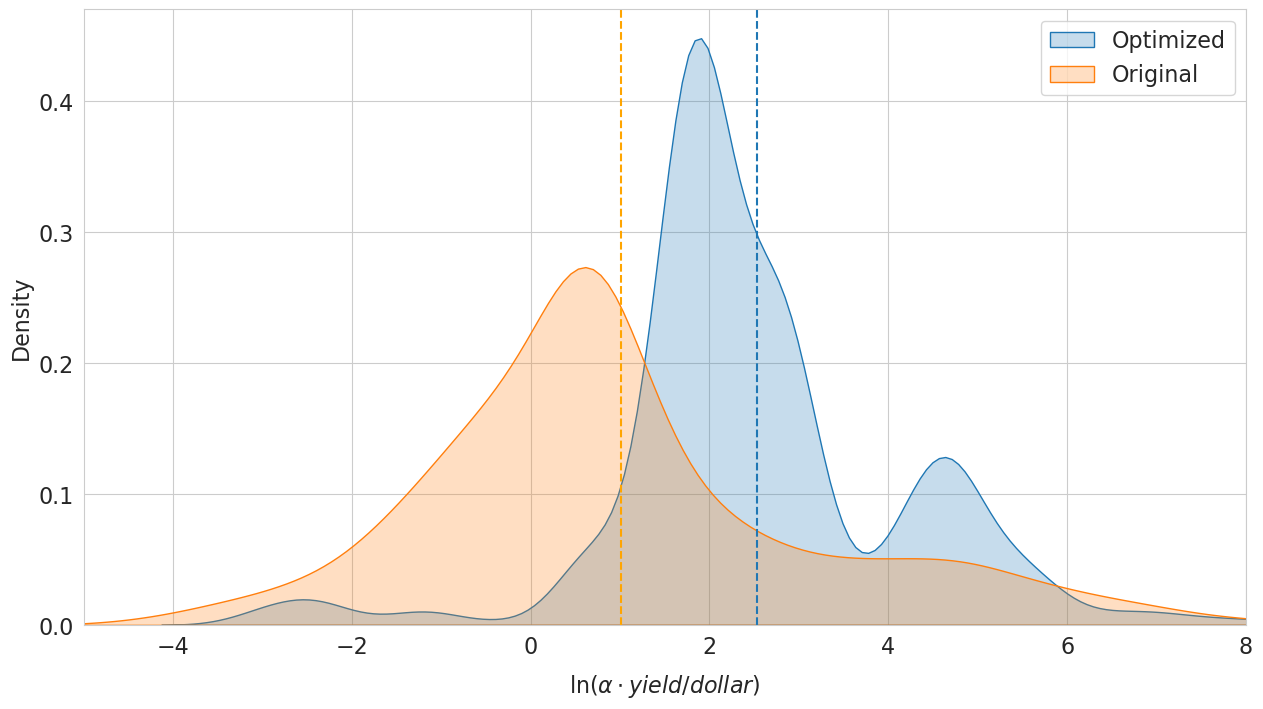

In [81]:
plt.figure(figsize=(15,8))
sns.kdeplot(results["vhat"], fill = True, label = "Optimized")
sns.kdeplot(results["original"],  fill = True, label = "Original")
plt.tick_params(labelsize=16)
plt.xlabel(r'$\ln (\alpha \cdot yield / dollar)$', fontsize = 16, labelpad= 10)
plt.axvline(x = results["vhat"].mean(), linestyle = "--", color = 'C0')
plt.axvline(x = results["original"].mean(), linestyle = "--", color = "orange")
plt.legend(fontsize= 16)
plt.ylabel("Density", fontsize = 16)
plt.savefig("figs/Yield Efficiency Optimum vs Original", bbox_inches = "tight")
plt.xlim((-5, 8))

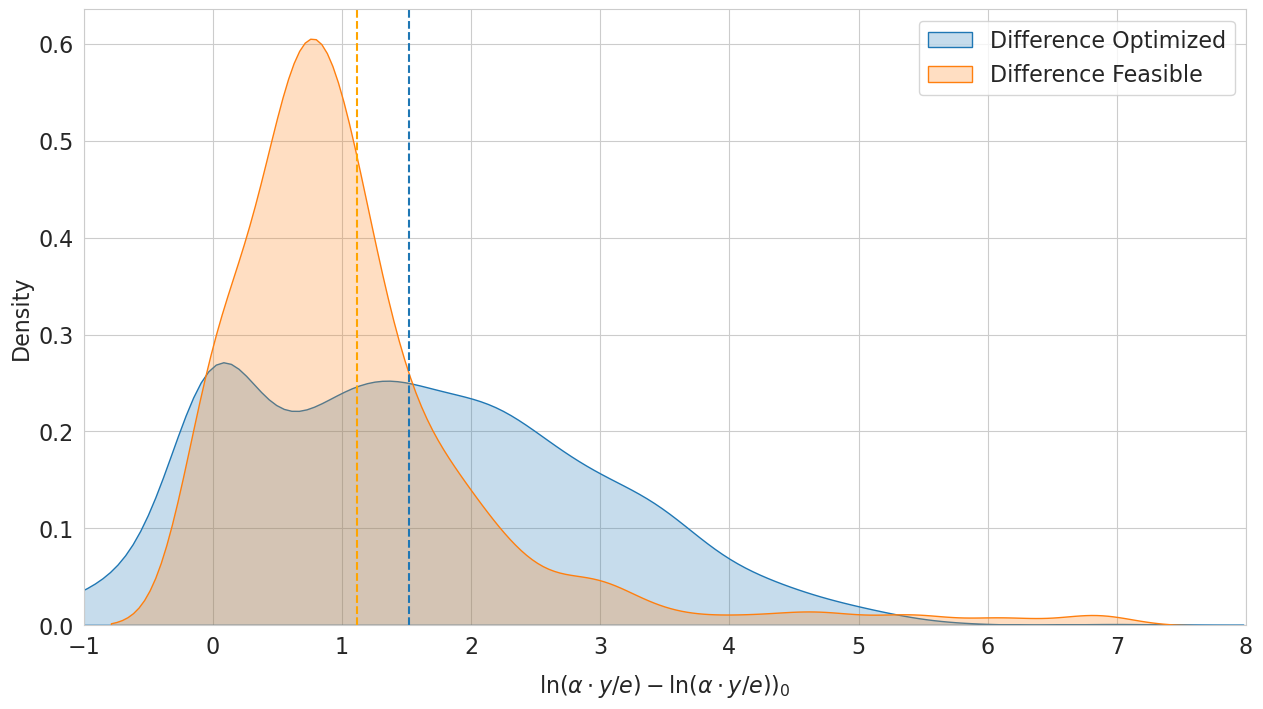

In [82]:
plt.figure(figsize=(15,8))
sns.kdeplot(results["vhat"] - results["original"], fill = True, label = "Difference Optimized")
sns.kdeplot(results["vstar"] - results["original"], fill = True, label = "Difference Feasible")
plt.axvline(x = (results["vhat"] - results["original"]).mean(), linestyle = "--", color = "C0")
plt.axvline(x = (results["vstar"] - results["original"]).mean(), linestyle = "--", color = "orange")
plt.tick_params(labelsize=16)
plt.xlabel(r'$\ln (\alpha \cdot y / e) - \ln (\alpha \cdot y / e))_0$', fontsize = 16, labelpad= 10)
plt.legend(fontsize= 16)
plt.ylabel("Density", fontsize = 16)
plt.xlim((-1, 8))
plt.savefig("figs/Yield Efficiency Optimum Feasible Difference", bbox_inches = "tight")

In [88]:
from scipy.stats import ttest_rel
rmse_xregr = 0.77
sensitivity_thresholds = [0, rmse_xregr, 2*rmse_xregr]

for sensitivity_threshold in sensitivity_thresholds:
    stat, pval = ttest_rel(results["vhat"] - sensitivity_threshold, results["original"], alternative = "greater")
    print(pval)

1.6246462647286204e-228
2.7041282524483336e-75
0.7294573192775038


In [90]:
(results["vhat"] - results["original"]).mean()

1.516642786709691

In [87]:
1.51-0.134

-0.005079999999999973

### Testing Area

In [485]:
df

,unitid,log_yield_per_dollar,Institutional grants (funded)_per_dollar,Institutional grants (unfunded)_per_dollar,Sales and services of educational activities - Total_per_dollar,Sales and services of auxiliary enterprises - Total_per_dollar,Instruction-Total amount_per_dollar,Research-Total amount_per_dollar,Public service-Total amount_per_dollar,Academic support-Total amount_per_dollar,Student service-Total amount_per_dollar,Institutional support-Total amount_per_dollar,Auxiliary enterprises-Total amount_per_dollar,Net grant aid to students-Total amount_per_dollar
0,100937,0.111066,0.120239,0.349113,0.000000,0.327833,0.308731,0.000000,0.000000,0.070772,0.204256,0.197669,0.211686,0.006885
1,101073,2.544717,0.000000,0.066926,0.000000,0.178585,0.309677,0.000000,0.000000,0.043623,0.084801,0.300184,0.261713,0.000000
2,101189,1.001058,0.012133,0.271563,0.000000,0.073259,0.397523,0.000000,0.000000,0.070137,0.209641,0.197334,0.101123,0.000000
3,101365,2.801799,0.000000,0.186007,0.000000,0.000000,0.403997,0.000000,0.000000,0.056023,0.298759,0.169485,0.000000,0.000000
4,101435,0.887857,0.179659,0.291876,0.000000,0.207451,0.300758,0.000000,0.000000,0.073726,0.297051,0.174625,0.153840,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,494463,0.661397,0.000000,0.015050,0.000000,0.143982,0.017276,0.000000,0.000000,0.006505,0.004565,0.007449,0.121990,0.000000
1334,494685,6.594540,0.010033,0.065556,0.000000,0.000000,0.286861,0.000000,0.000000,0.117500,0.295833,0.262713,0.000000,0.000000
1335,495031,5.185335,0.000000,0.636105,0.000000,0.000000,0.313956,0.000000,0.025573,0.000000,0.087929,0.094743,0.000000,0.477798
1336,495767,-4.521554,0.011316,0.018258,0.014545,0.051884,0.179063,0.123366,0.014536,0.050001,0.026074,0.051233,0.054352,0.000000


In [497]:
from sklearn.model_selection import train_test_split
X, y = df.iloc[:, 2:], df.iloc[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators = 20, random_state=0)

regr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=0)

In [498]:
from sklearn.metrics import r2_score, mean_squared_error

print(f"R^2: {r2_score(y_test, regr.predict(X_test))}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, regr.predict(X_test)))}")

R^2: 0.5711633088312353
RMSE: 1.4945370933080349


In [ ]:
test = np.array([[1,2, 3], [2,3, 4], [3,4, 5], [4, 5, 6]])
mask = test > np.array([2, 3, 4, 5]).reshape(-1, 1)

altered_test = np.where(mask, test, np.PINF)
softmax(-altered_test, axis = 1)

array([[-inf, -inf,  -3.],
       [-inf, -inf,  -4.],
       [-inf, -inf,  -5.],
       [-inf, -inf,  -6.]])

In [ ]:
df = pd.DataFrame(np.random.randn(50, 1), columns=list('A'))
df["E"] = 2*np.arange(0, 50)
df2 = pd.DataFrame(np.random.randn(100, 1), columns=list('B'))
df2 = pd.DataFrame(np.random.randn(100, 1), columns=list('B'))

In [ ]:
df3 = pd.merge(df2.reset_index(), df,  how="right", on = "E").set_index('index')
df3

In [5]:
neighbor_values = np.arange(24).reshape(4, 3, 2)
weights = np.array([[0.3, 0.3, 0.4], [0.9, 0.1, 0], [0.6, 0.2, 0.2], [0, 0, 1]])

In [6]:
np.sum(neighbor_values * weights[:, :, None], axis = 1)

array([[ 2.2,  3.2],
       [ 6.2,  7.2],
       [13.2, 14.2],
       [22. , 23. ]])

In [8]:
neighbor_values[:, :, 1] = np.arange(4).reshape(-1,1)

In [9]:
neighbor_values

array([[[ 0,  0],
        [ 2,  0],
        [ 4,  0]],

       [[ 6,  1],
        [ 8,  1],
        [10,  1]],

       [[12,  2],
        [14,  2],
        [16,  2]],

       [[18,  3],
        [20,  3],
        [22,  3]]])

In [ ]:
# if self.total_column_lab is not None:
#     lb[self.total_column_index] = x0[self.total_column_index]
#     ub[self.total_column_index] = x0[self.total_column_index]
#     all_but_total = [x for x in range(d) if x != self.total_column_index]
#     lb[all_but_total] = x0[all_but_total] - eps * x0[all_but_total]
#     ub[all_but_total] = x0[all_but_total] + eps * x0[all_but_total]
# else:
#     lb = x0 - eps * x0
#     ub = x0 + eps * x0